# Libraries

In [67]:
import importlib
import strava_data
import strava_data.authentication
import strava_data.visualization
importlib.reload(strava_data)
importlib.reload(strava_data.authentication)
importlib.reload(strava_data.visualization)
from strava_data.authentication import login
import strava_data.visualization as vis
import pandas as pd
import numpy as np

# Login

In [58]:
client = login()

No rates present in response headers


You have already authenticated once before. Refreshing your token now.
Hi Joey, authentication successful!


# Get activities

In [59]:
activities_object = client.get_activities(limit=1000)
activities = list(activities_object)

def get_activity_data(activity):
    activity_dict = dict(activity)
    col_names = ['id','type', 'name', 'distance', 'moving_time', 'elapsed_time',
                 'total_elevation_gain', 'start_date', 'start_latlng', 'kilojoules',
                 'average_heartrate', 'max_heartrate', 'elev_high', 'elev_low',
                 'average_speed', 'max_speed']
    activity_data = {k: activity_dict[k] for k in col_names}
    return activity_data

activities_data = [get_activity_data(a) for a in activities]
df_activities = pd.DataFrame(activities_data)

# Weekly stack plots

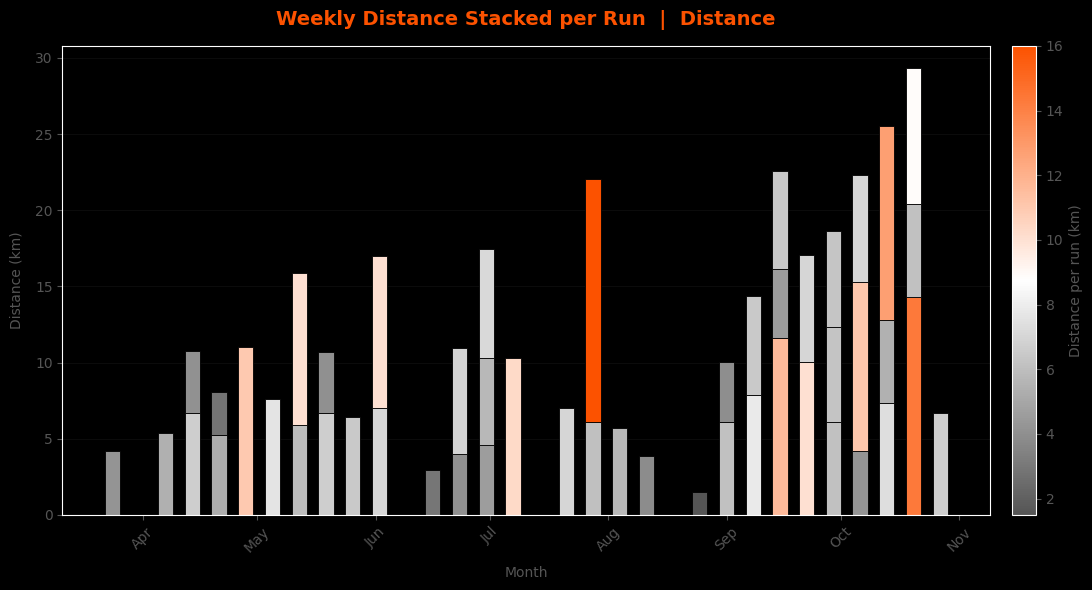

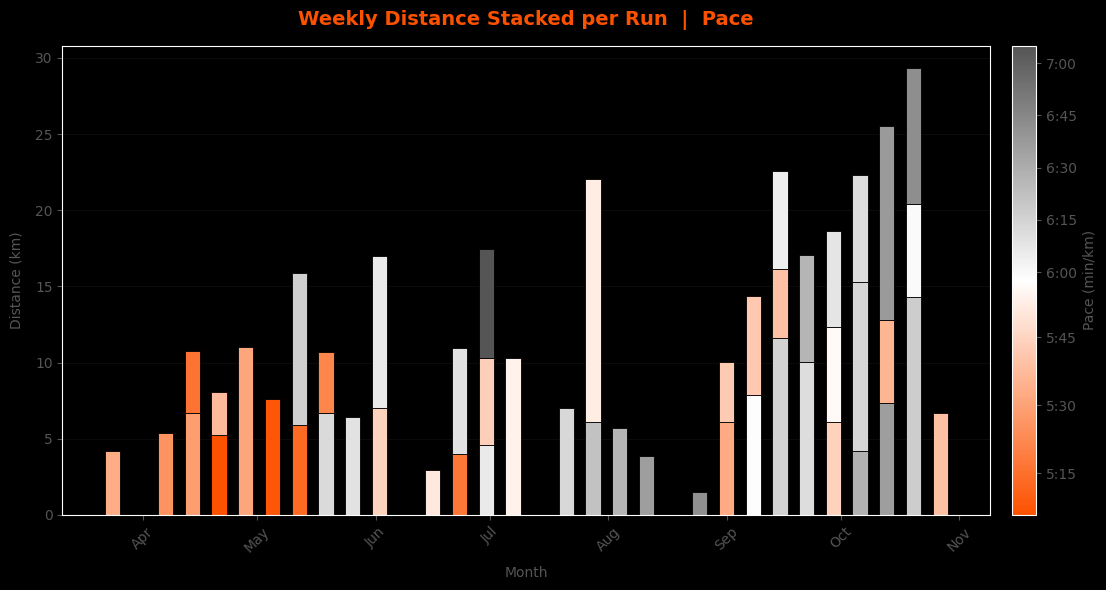

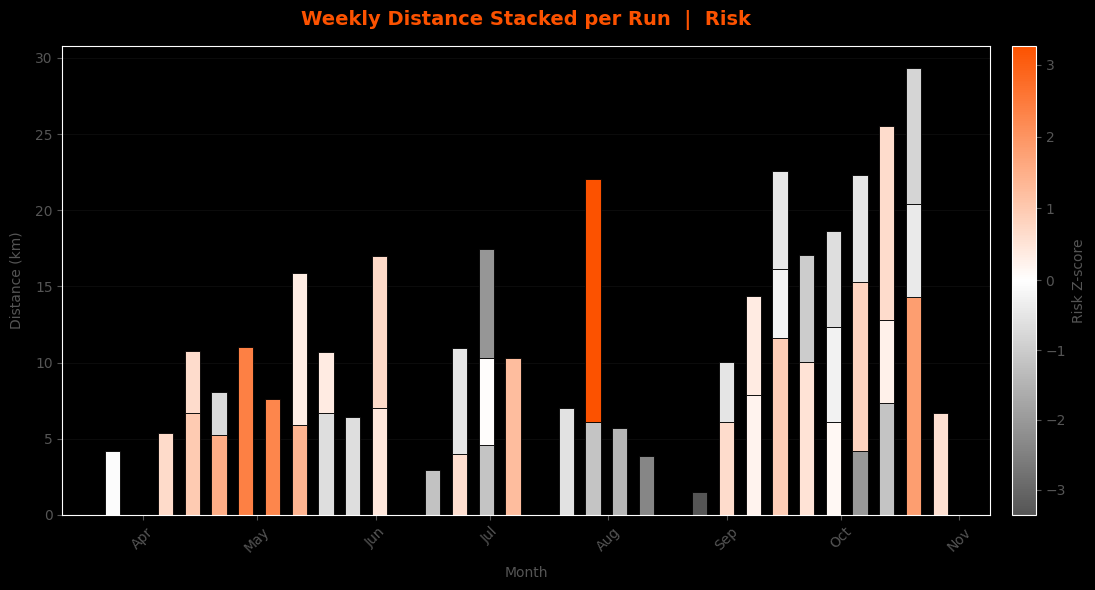

In [60]:
vis.plot_weekly(df_activities, col='distance', save_name='weekly_distance.png')
vis.plot_weekly(df_activities, col='pace', save_name='weekly_pace.png')
vis.plot_weekly(df_activities, col='risk', save_name='weekly_risk.png')

# Weekly targets

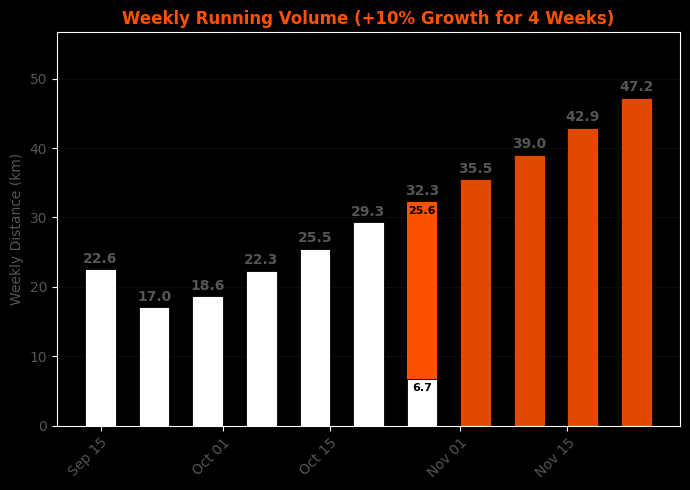

In [61]:
vis.plot_weekly_distance_targets(df_activities, additional_weeks=4, save_name=f'weekly_distance_target_progression.png')

# Example week plans

In [62]:
df_activities['start_date'] = pd.to_datetime(df_activities['start_date'], utc=True)
df_runs = df_activities[
    (df_activities['type'] == "Run") &
    (df_activities['start_date'].dt.year >= 2025)
].copy()

df_runs['distance_km'] = df_runs['distance'] / 1000
df_runs['week'] = df_runs['start_date'].dt.to_period('W-SUN').apply(lambda r: r.end_time)   

weekly = df_runs.groupby('week')['distance_km'].agg(
    total_volume='sum',
    long_run='max'
).sort_index()

 # --- Current week ---
now = pd.Timestamp.now(tz=df_runs['start_date'].dt.tz)
this_week = now.to_period('W-SUN').end_time

if this_week not in weekly.index:
    weekly.loc[this_week] = {'total_volume': 0, 'long_run': 0}
weekly = weekly.sort_index()

In [63]:
week_target = round(float(weekly.iloc[-2]['total_volume'] * 1.1), 1)
week_target

32.3

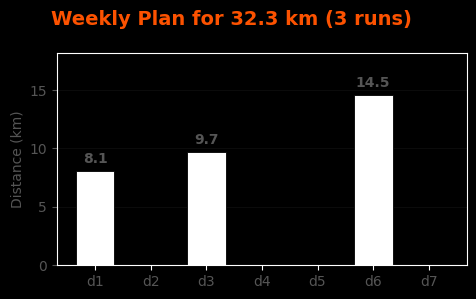

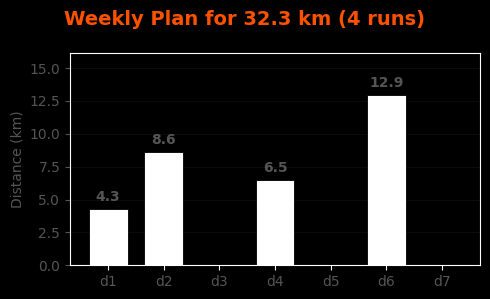

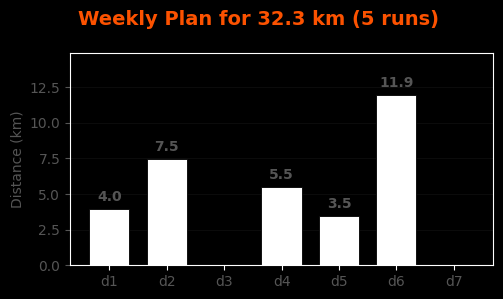

In [64]:
for runs in [3, 4, 5]:
    vis.plot_week_plan(week_target, runs, save_name=f'week_plan_{runs}_runs.png')

# Proposed week plans given current week's runs

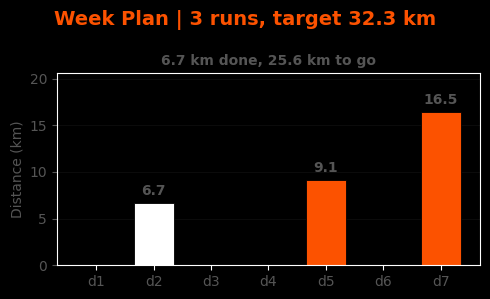

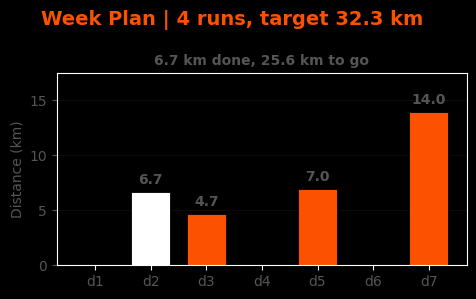

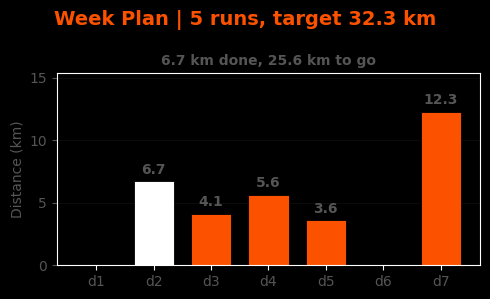

In [68]:
for runs in [3, 4, 5]:
    vis.plot_current_week_plan(df_activities, week_target, runs=runs, save_name=f'current_week_plan_{runs}_runs.png')